In [1]:
import os
import json
from matplotlib import pyplot as plt
import numpy as np
from datascience import *
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [3]:
timestamps_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps"
timestamps = [os.path.join(timestamps_dir, ts) for ts in os.listdir(timestamps_dir)]
timestamps[0]

'/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps/17709_01-03-2016_78_Toronto Raptors_7_Chicago Bulls_period3.json'

In [4]:
import os
fp = 'processed_vids.txt'
dir_p = timestamps_dir
with open(fp, 'w') as f:
    vids = os.listdir(dir_p)
    for v in vids:
        f.write(v)
        f.write('\n')
vids = os.listdir(dir_p)
print(len(vids))

282


In [7]:
def interpolate(time_remaining):

    time_remaining = time_remaining.copy()
    fps = 30
    multiplier = 0
    decreasing = False

    for i in range(len(time_remaining) - 1):
        current, next_value = time_remaining[i], time_remaining[i + 1]
        peak_value = time_remaining[min(i + fps, len(time_remaining) - 1)]

        if current == 0:
            continue

        decreasing = peak_value < current
        if decreasing:
            if multiplier > 30:
                multiplier, decreasing = 0, False
                continue

            time_remaining[i] -= round((1/30) * multiplier, 2)
            multiplier = 0 if next_value < current else multiplier + 1
        # else:
        #     time_remaining[i] = 0

    return time_remaining

In [8]:
import json

def update_time_remaining(remove_indices, time_remaining):
    for idx, remove in enumerate(remove_indices):
        if remove:
            # Find nearest neighbor with remove == 0
            left_idx = idx - 1
            right_idx = idx + 1
            while left_idx >= 0 and remove_indices[left_idx]:
                left_idx -= 1
            while right_idx < len(remove_indices) and remove_indices[right_idx]:
                right_idx += 1
            # Choose the closest valid neighbor
            if left_idx >= 0 and (right_idx >= len(remove_indices) or (idx - left_idx) <= (right_idx - idx)):
                time_remaining[idx] = time_remaining[left_idx]
            elif right_idx < len(remove_indices):
                time_remaining[idx] = time_remaining[right_idx]

def moving_average(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

def normalize(arr):
    _min, _max = arr.min(), arr.max()
    return (arr - _min) / (_max - _min)

def denoise_time_remaining(time_remaining):
    def update_time_remaining(remove_indices, time_remaining):
        valid_indices = np.where(remove_indices == 0)[0]
        for idx in np.where(remove_indices)[0]:
            nearest_valid_index = valid_indices[np.argmin(np.abs(valid_indices - idx))]
            time_remaining[idx] = time_remaining[nearest_valid_index]

    time_remaining = np.array(time_remaining)
    time_remaining_og = time_remaining.copy()
    expected = np.linspace(0, 720, len(time_remaining), endpoint=False)[::-1]
    norm_expected_diff = normalize(np.abs(expected - time_remaining_og))
    remove_indices = (norm_expected_diff > 0.5).astype(int)
    update_time_remaining(remove_indices, time_remaining)

    for window in [1000, 500]:
        if len(time_remaining) > window:
            mvg_avg = moving_average(time_remaining, window)
            padded_avg = np.pad(mvg_avg, (window // 2, window - window // 2 - 1), mode='edge')
            norm_diff = normalize(np.abs(time_remaining - padded_avg))
            remove_indices = (norm_diff > 0.5).astype(int)
            update_time_remaining(remove_indices, time_remaining)

    for window in [50, 10, 5]:
        if len(time_remaining) > window:
            mvg_avg = moving_average(time_remaining, window)
            padded_avg = np.pad(mvg_avg, (window // 2, window - window // 2 - 1), mode='edge')
            norm_diff = normalize(np.abs(time_remaining - padded_avg))
            remove_indices = (norm_diff > 0.01).astype(int)
            update_time_remaining(remove_indices, time_remaining)

    temp_interpolated = interpolate(time_remaining)
    delta = np.gradient(temp_interpolated)
    delta_inter = normalize(moving_average(abs(delta), 7))
    remove_indices = (delta_inter > 0.1).astype(int)
    update_time_remaining(remove_indices, time_remaining)

    return time_remaining

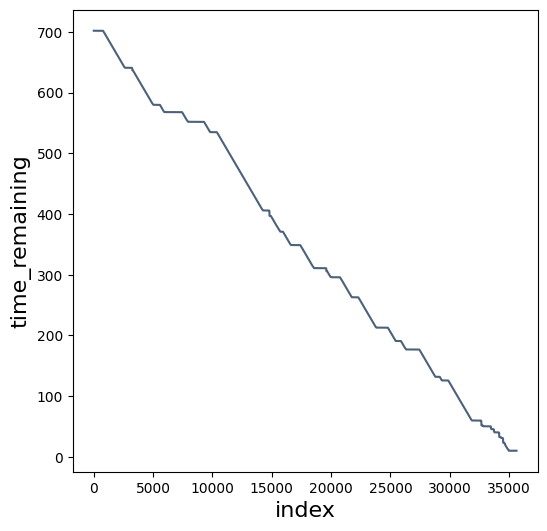

In [9]:
from post_processing import get_time_remaining_from_timestamps
from post_processing import post_process_timestmaps

i = 16

def get_timestamps_from_fp(fp):
    with open(fp, 'r') as f:
        return get_time_remaining_from_timestamps(json.load(f))

time_remaining = get_timestamps_from_fp(timestamps[i])
indicies = np.arange(0, len(time_remaining))

t = Table().with_columns(
    'index', indicies,
    'time_remaining', time_remaining,
)
t.plot('index')

In [10]:
vids_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/game-replays/720"
vids = os.listdir(vids_dir)
names = []

for vid in vids:
    name = vid.split('_period')[0]
    names.append(name)

len(set(names))

650

In [11]:
s = '17915_12-04-2015_21_Portland Trail Blazers_9_Indiana Pacers_period2.mp4'
s.split('_period')[0]

'17915_12-04-2015_21_Portland Trail Blazers_9_Indiana Pacers'

In [12]:
from tqdm import tqdm

timestamps_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps/post-processed"
videos_base_dir = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/My Mac/720'
timestamps = [os.path.join(timestamps_dir, ts) for ts in os.listdir(timestamps_dir)]

def equalize_array_lengths(array1, array2):
    length = min(len(array1), len(array2))
    return array1[:length], array2[:length]

def mean_diff(arr):
    expected = np.arange(0, 720, 720 / len(arr))[::-1]
    expected, arr = equalize_array_lengths(expected, arr)
    diffs = np.absolute(expected - arr)
    return np.mean(diffs)

ids = []
og_mean_diffs = []
pp_mean_diffs = []

for fp in tqdm(timestamps):
    try:
        if not fp.endswith('.json'):
            og_mean_diffs.append(-1)
            pp_mean_diffs.append(-1)
            id = -1
        else:
            time_remaining = get_timestamps_from_fp(fp)
            print(time_remaining)
            _mean_diff = mean_diff(time_remaining)
            og_mean_diffs.append(_mean_diff)
            id = fp.split("_")[3].split('/')[-1]
    except:
        raise Exception(fp)
    ids.append(id)

  2%|▏         | 5/237 [00:00<00:03, 65.57it/s]


[ 710.   710.   710.  ...,   10.2   10.2   10.2]
[ 715.   715.   715.  ...,   10.8   10.8   10.8]
[ 704.   704.   704.  ...,   10.3   10.3   10.3]
[ 713.   713.   713.  ...,   10.2   10.2   10.2]
[ 709.   709.   709.  ...,   10.1   10.1   10.1]


Exception: /Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps/post-processed/17864_12-12-2015_3175_Phoenix Suns_21_Portland Trail Blazers_period4.json

In [ ]:
videos_paths = [os.path.join(videos_base_dir, fp.split('/')[-1].replace('.json', '.mp4')) for fp in timestamps]
titles = [fp.split('/')[-1].replace('.json', '') for fp in timestamps]

timestamps_noise_scores: Table = Table().with_columns(
    'index', np.arange(0, len(ids)),
    'game_id', ids,
    'noise_score', og_mean_diffs,
    'eligible', ~np.greater_equal(og_mean_diffs, 70),
).sort('noise_score', descending=True)
timestamps_noise_scores.show(40)

timestamps_noise_scores.where('eligible', are.equal_to(True)).num_rows / timestamps_noise_scores.num_rows

index,game_id,noise_score,eligible
0,18043,nan,True
1,17966,nan,True
2,164621,nan,True
3,17803,nan,True
4,707,nan,True
5,169460,nan,True
6,18106,nan,True
7,164109,nan,True
8,18096,nan,True
9,18109,nan,True


1.0

In [ ]:
import json
from viz import *

i = 18
_i = timestamps_noise_scores.column('index').item(i)

time_remaining = get_time_remaining_from_timestamps(timestamps[_i])
denoised_time_remaining = denoise_time_remaining(time_remaining)
interpolated_time_remaining = interpolate(denoised_time_remaining)

def update_timestamps(src_path, dst_path, time_remaining):
    with open(src_path, 'r') as f:
        timestamps = json.load(f)
    for k, v in enumerate(time_remaining):
        timestamps[str(k)]['time_remaining'] = v
    with open(dst_path, 'w') as f:
        json.dump(timestamps, f)

src_fp = timestamps[_i]
dst_path = os.path.join('demo/timestamps_dir', 'example.json')
update_timestamps(
    src_path=src_fp,
    dst_path=dst_path,
    time_remaining=interpolated_time_remaining
)

viz_dir = 'demo/viz_dir'
vp = timestamps_noise_scores.column('video_path').item(i)
tp = dst_path
out_path = os.path.join(viz_dir, timestamps_noise_scores.column('game_title').item(i)) + '.avi'
visualize_timestamps(
    vp,
    tp,
    out_path
)

In [ ]:
from testing.test_suite import *

run_all_tests()

In [ ]:
from temporal_grounding import *

image = Image.open(
    "testing/assets/example_cropped_rois/time_remaining/time_remaining_1.PNG")
results = extract_text_with_paddle(image)
assert results == ["2:41"], f'Expected: {["2:41"]}, actual: {results}'

In [ ]:
import os

dir = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/game-replays/720'
len(os.listdir(dir))

2551

In [ ]:
import os

os.listdir('/Users/leviharris/Library/CloudStorage/GoogleDrive-mark.harris@bcsemail.org/Shared drives')

[]

In [ ]:
'2024 SOFTWARE ENGINEER PROGRAM'.lower()

'2024 software engineer program'